# Fisher matrix for Supernovae type Ia (SNIa)

(First version: March 2020)

(Revised version: September 2024)

Domenico Sapone 

In [1]:
import matplotlib

import matplotlib.pyplot as plt
import numpy as np

import functools


import math

import scipy 
import scipy.special as ssp
import scipy.integrate as integrate
import scipy.stats as stats
from scipy import interpolate
from scipy.misc import derivative
from scipy.interpolate import interp1d
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.interpolate import UnivariateSpline

#import sys, platform, os
import time
from math import *


from functools import reduce #python 3
from numpy.linalg import inv


#For C-compilation just in time (requires numba reachable with conda install numba)
#from numba import jit 

interp_type = 'cubic' 







In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

### Set your cosmology

Here we define the cosmological parameters, which are usually called the physical parameters. 

These are provided by a Boltzmann solver, not really needed here, just in case you decided to take as input a product of the Boltzmann solver. 


Input parameters
\begin{equation}
\{\omega_{\rm b} h^2,\,h,\,\omega_{\rm m} h^2\}\,.
\end{equation}
Other parameters 
\begin{equation}
\Omega_{\rm r} =0\,.
\end{equation}
The last one is, in general not zero, assumed here since we are doing late time cosmology. 


In [3]:

[omegabh2ref, href, omegamh2ref] = [0.022445, 0.67, 0.143648]


clight = 299792.458 #km/sec



parsin =['h', 'om', 'oml', 'w0', 'wa']
[href, om0ref, oml0ref, w0ref, waref] = [0.67, omegamh2ref/href**2, 1 - omegamh2ref/href**2, -1, 0]




### Functions we need: background observables

You need to choose your favourite cosmological model, let's start with the non flat DE-CDM model is


\begin{equation}
H(z) = H_0 \sqrt{\Omega_{m,0} (1+z)^3+(1-\Omega_{m,0}-\Omega_{\Lambda,0})(1+z)^2+\Omega_{\Lambda,0}(1+z)^{3(1+w(z))}}
\end{equation}
We may want to make some assumptions at the beginning to speed up calculations and to take under control the possible sources of errors. 

Let's consider $\Lambda$CDM model, i.e. the cosmological constant, this implies:
\begin{equation}
w(z) = -1
\end{equation}
We can also simplify our lifes a bit more and assume flat cosmology, in this case, the Hubble parameter becomes 


\begin{equation}
H(z) = H_0 \sqrt{\Omega_{m,0} (1+z)^3 + (1-\Omega_{m,0})}
\end{equation}

Clearly, now we're left with only one parameter to play with: $\Omega_{m,0}$, because as mentioned and as we will see later $H_0$ cannot be considered as a free parameter. Usually, we have 
\begin{equation}
H_0 = 100\,h\, {\rm Km/s/Mpc}
\end{equation}
and $h$ is the reduced Hubble parameter and it is dimensionless. 

Another function that it is useful is 
\begin{equation}
E(z) = \frac{H(z)}{H_0}
\end{equation}


In [4]:



def eez(z, om, oml, w):
    """Calculate E(z) for given z, om, oml, and w."""
    return np.sqrt(om * (1 + z)**3 + (1 - om - oml) * (1 + z)**2 + oml * (1 + z)**(3 * (1 + w)))


def eea(a, om, oml, w, tol=1e-10):
    """
    Calculate E(a) where a is the scale factor, 
    by transforming from z = 1/a - 1.
    
    Parameters:
    - a: Scale factor (or an array of scale factors)
    - om: Matter density parameter
    - oml: Lambda density parameter (Dark Energy)
    - w: Equation of state parameter for Dark Energy
    - tol: Tolerance to avoid division by zero when a approaches 0
    """
    a = np.clip(a, tol, 1.0)  # Ensure 'a' stays within bounds (avoid division by zero)
    z = 1 / a - 1
    return eez(z, om, oml, w)


### Distance

We need to define the distances. 

The comoving distance to an object at redshift $z$ can be computed as
\begin{equation}
r(z) = \frac{c}{H_0} \int_0^z\frac{{\rm d}x}{E(x)}
\end{equation}
Warning! This is not a direct observable, it is closely related to other distance definitions that are directly linked with cosmological observations. 
For our pourpose we define the angular diameter distant

\begin{eqnarray}
  && \,\,\,\frac{1}{1+z}\frac{c}{H_0}\frac{1}{\sqrt{|\Omega_{k,0}|}}\sin\left(\sqrt{|\Omega_{k,0}|}\frac{H_0}{c}r(z)\right) \hspace{1cm}\text{if }\,\Omega_{K,0} <0\\
D_A(z) \,\,\, &=& \,\,\,\frac{1}{1+z}r(z) \hspace{6.3cm}\text{if }\,\Omega_{K,0} =0\\
&&\,\,\,\frac{1}{1+z}\frac{c}{H_0}\frac{1}{\sqrt{\Omega_{k,0}}}\sinh\left(\sqrt{\Omega_{k,0}}\frac{H_0}{c}r(z)\right) \hspace{1cm}\text{if }\,\Omega_{K,0} >0
\end{eqnarray}

We may want to make some assumptions at the beginning to speed up calculations 
and to take under control the possible sources of errors.

For SNIa we're interested in Luminosity distance: 
\begin{equation}
D_L(z) = (1+z)^2 D_A(z)
\end{equation}

In [5]:
# Number of steps for z grid
stepode = 12


# Cached function to compute r(z)
#@functools.lru_cache(maxsize=250)

def r_of_z1(om, oml, w):
    zgrid = np.linspace(0, 2., 2**stepode + 1)
    dz = np.diff(zgrid)[0]
    I1 = np.cumsum(dz / eez(zgrid, om, oml, w))
    
    # Cubic interpolation
    interpo = scipy.interpolate.interp1d(zgrid, I1, kind='cubic', fill_value='extrapolate')
    return interpo


# Function for r(z) using the cached r_of_z1
def r_of_z(z, om, oml, w):
    r_interp = r_of_z1(om, oml, w)
    return r_interp(z) - r_interp(0)


# Luminosity distance function
def distl(z, h, om, oml, w):
    omk = 1 - om - oml
    """
    Constant factor which will be marginalized over: c/H_0
    """
    cH0 = clight / (100 * h) 
    """
    Calculate D_L(z) where z is the redshift. 
    
    Parameters:
    - z: redshift (or an array of redshift)
    - om: Matter density parameter
    - oml: Lambda density parameter (Dark Energy)
    - w: Equation of state parameter for Dark Energy
    - omk: if statement to choose the appropriate form of the comoving distance
    """    
    r_z = r_of_z(z, om, oml, w)

    if omk == 0:
        distzi = cH0 * (1 + z) * r_z
    elif omk < 0:
        distzi = cH0 * (1 + z) / np.sqrt(abs(omk)) * np.sin(np.sqrt(abs(omk)) * r_z)
    else:  # omk > 0
        distzi = cH0 * (1 + z) / np.sqrt(abs(omk)) * np.sinh(np.sqrt(abs(omk)) * r_z)

    return distzi



#### Start evaluating computational time for possible bottleneck. 

In [6]:
# Timing and testing the function

z_grid_test = np.arange(0, 2, 0.001)

start_time = time.time()

# Test with a range of redshift values
test_time = distl(z_grid_test, href, om0ref, oml0ref, w0ref)

print("--- %s seconds ---" % (time.time() - start_time))
print(test_time)

--- 0.0035278797149658203 seconds ---
[0.00000000e+00 4.47738860e+00 8.96156948e+00 ... 1.59341352e+04
 1.59438506e+04 1.59535669e+04]


Usefull: you can also think of vectorizing the computation. In this specific case, we do not need it as the gain is not significant.

We redefine the functions: 

In [7]:

# Cached r_of_z1 function for interpolation
def r_of_z1_new(om, oml, w, zgrid):
    dz = np.diff(zgrid)[0]
    I1 = np.cumsum(dz / eez(zgrid, om, oml, w))
    return I1

# Vectorized r(z) using interpolation over the zgrid
def r_of_z_new(z, om, oml, w, zgrid):
    r_vals = r_of_z1_new(om, oml, w, zgrid)
    r_interp = scipy.interpolate.interp1d(zgrid, r_vals, kind='cubic', fill_value='extrapolate')
    return r_interp(z) - r_interp(0)


# Vectorized luminosity distance calculation
def distl_new(z_vals, h, om, oml, w):
    omk = 1 - om - oml
    cH0 = clight / (100 * h)
    zgrid = np.linspace(0, 2., 2**12 + 1)  # Use the same z-grid for interpolation

    r_vals = r_of_z_new(z_vals, om, oml, w, zgrid)
    
    if omk == 0:
        dist_vals = cH0 * (1 + z_vals) * r_vals
    elif omk < 0:
        dist_vals = cH0 * (1 + z_vals) / np.sqrt(abs(omk)) * np.sin(np.sqrt(abs(omk)) * r_vals)
    else:  # omk > 0
        dist_vals = cH0 * (1 + z_vals) / np.sqrt(abs(omk)) * np.sinh(np.sqrt(abs(omk)) * r_vals)

    return dist_vals



In [8]:
# Timing and testing the function
start_time = time.time()

# Test with a range of redshift values
test_time = distl_new(z_grid_test, href, om0ref, oml0ref, w0ref)

print("--- %s seconds ---" % (time.time() - start_time))
print(test_time)

--- 0.0032880306243896484 seconds ---
[0.00000000e+00 4.47738860e+00 8.96156948e+00 ... 1.59341352e+04
 1.59438506e+04 1.59535669e+04]


### Distance modulus

What catalogs really give for SNIa? 

They actually five the lightcurves, i.e. the luminosity of the SN explosion as a function of time. 
However, cosmologist prefer to trust astronomers and we use the "reduced" data, which is called: the distance modulus, defined as
\begin{equation}
\mu(z) = 5 \log \left(D_L(z)\right) + M_0 = 5\log \left(\frac{c}{H_0} d_L(z)\right) + M_0 = 5\log \left(d_L(z)\right)+M_0+5\log\frac{c}{H_0}
\end{equation}
and 
\begin{equation}
\mu(z) = 5\log \left(d_L(z)\right)+\mathcal{M}_0
\end{equation}

There is no way, with SNIa, to measure $H_0$ as it appears as a constant into the equations and it is degenarate with $M_0$. If you calibrate SNIa, i.e. we assume $M_0$ known, than we can infer $H_0$ and we have Riess et al aka tension problem! 

In [9]:
# Theoretical distance modulus function
def mu_th(z, h, om, oml, w):
    return 5 * np.log10(distl(z, h, om, oml, w))


The discussion above is a bit simplistic but we apply it here just as an example. 

In reality the distance modulus of SNIa comes from the light curves, i.e. flux over time. 

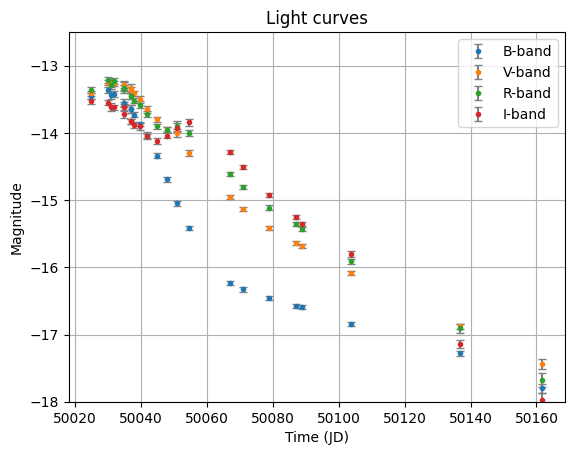

In [10]:
test_1 = np.loadtxt('cfalc_allsnIa/sn1995al_BVRI.dat')
test_2 = np.loadtxt('cfalc_allsnIa/sn1995E_BVRI.dat')


# Define the band columns and labels
bands = {
    'B-band': (1, 2),
    'V-band': (3, 4),
    'R-band': (5, 6),
    'I-band': (7, 8)
}



# Plot using a loop
for label, (magnitude_col, error_col) in bands.items():
    plt.errorbar(test_1[:, 0], -test_1[:, magnitude_col], yerr=test_1[:, error_col], fmt='.', ecolor='gray', capsize=3, label=label)


# Customize the plot
plt.xlabel('Time (JD)')
plt.ylabel('Magnitude')
plt.title('Light curves')
plt.ylim(-18, -12.5)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()



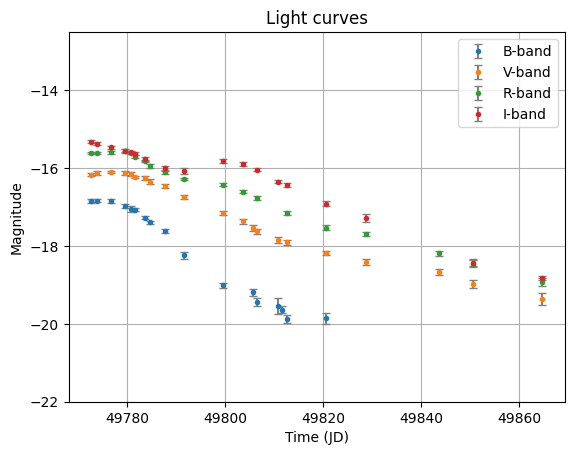

In [11]:
# Plot using a loop
for label, (magnitude_col, error_col) in bands.items():
    plt.errorbar(test_2[:, 0], -test_2[:, magnitude_col], yerr=test_2[:, error_col], fmt='.', ecolor='gray', capsize=3, label=label)


# Customize the plot
plt.xlabel('Time (JD)')
plt.ylabel('Magnitude')
plt.title('Light curves')
plt.ylim(-22, -12.5)
plt.legend()
plt.grid(True)

Converting light curve to distance modules is not a trivial task, however there are public codes that'll do the job: SNANA and SALT3

Other systematic effects need to be taken into account: 

- $X_1$ is the stretch of the supernova;
- $C$ its color;
- $M_B$ the intrinsic luminosity. 

The full distance modules will be then 
$$\mu(z) = 5\log \left(d_L(z)\right)+ M_0 − \alpha\,X_1 + \beta\,C $$


We define the likelihood function as:
$$
\mathcal{L} = (2 \pi)^{-N/2} \det (\Sigma)^{-1/2} \exp \left( -\frac{1}{2} (\tilde{\mu}_{\text{obs}} - \tilde{\mu})^\top \Sigma^{-1} (\tilde{\mu}_{\text{obs}} - \tilde{\mu}) \right)
$$

We model the covariance matrix as diagonal, defined by:
$$
\Sigma = \sigma_m^2 + \sigma_{\text{lens}}(z)^2 + \sigma_z(z)^2 + \beta^2 \sigma_C^2(z) + \alpha^2 \sigma_{X_1}^2(z) + 2 \alpha \sigma_m \sigma_{X_1}(z) - 2 \beta \sigma_{C m}(z) - 2 \alpha \beta \sigma_{X_1 C}(z)
$$
where:
- $\sigma_m$ is the error in determining the SN magnitude;
- $\sigma_{\text{lens}}$ is the error due to the lensing of the SN, with its redshift dependence modeled as $\sigma_{\text{lens}}(z) = \sigma_{\text{lens}} z$;
- $\sigma_z$ is the error in determining the SN redshift, modeled as $\sigma_z(z) = \frac{5 \sigma_z}{z \ln(10)}$;
- $\sigma_C$ is the error in determining the SN color, with its redshift dependence modeled as $\sigma_C(z) = \sigma_{C0} + \sigma_{C2} z^2$;
- $\sigma_{X_1}$ is the error in determining the SN stretch, with its redshift dependence modeled as $\sigma_{X_1}(z) = \sigma_{X_{10}} + \sigma_{X_{12}} z^2$;
- $\sigma_{m X_1}$ is the error in the joint determination of the stretch and magnitude of the supernova, with its redshift dependence modeled as $\sigma_{m X_1}(z) = \sigma_{m X_{10}} + \sigma_{m X_{12}} z^2$;
- $\sigma_{C m}(z)$ is the error in the joint determination of the color and magnitude of a supernova, with its redshift dependence modeled as $\sigma_{C m}(z) = \sigma_{C m 0} + \sigma_{C m 2} z^2$;
- $\sigma_{X_1 C}(z)$ is the error in the joint determination of the SN stretch and color, with its redshift dependence modeled as $\sigma_{X_1 C}(z) = \sigma_{X_1 C 0} + \sigma_{X_1 C 2} z^2$.

With this at hand, we can compute the Fisher matrix, which becomes:
$$
F_{ab} = \left\langle \frac{\partial m_i}{\partial p_a} \Sigma_{ij}^{-1} \frac{\partial m_j}{\partial p_b} \right\rangle + \frac{1}{2} \left\langle \text{Tr} \left( \Sigma^{-1} \frac{\partial \Sigma}{\partial p_a} \Sigma^{-1} \frac{\partial \Sigma}{\partial p_b} \right) \right\rangle_D
$$

SNANA creates light curves https://github.com/RickKessler/SNANA/blob/master/doc/snana_manual.pdf

SALT3 takes light cuves and transform to distance moduli https://github.com/jpierel14/SALT3?tab=readme-ov-file

### Creating mock catalog 

We need this as our benchmark survey: at the end we will need the redshifts of the SNIa

In [12]:
# Mock supernova distribution function
def snia_distribution(z_max=1.5, N=10000):
    """
    Create a mock catalog of supernova redshifts with a realistic distribution.
    """
    zs = np.random.rand(N)**(1/2.5) * z_max
    zs.sort()
    return zs

# Generate mock supernova redshifts
z_max = 2.5
N = 10000
zs = snia_distribution(z_max=z_max, N=N)

# Compute the distance moduli for each redshift
distance_moduli = mu_th(zs, href, om0ref, oml0ref, w0ref)

# Function to generate errors on the distance moduli based on redshift
def snia_distance_moduli_errors(zs, sigma_int=0.1, sigma_lens_0=0.055, sigma_z=0.001):
    """
    Generate errors for the distance moduli based on redshift and a realistic model.
    """
    sigma_lens = sigma_lens_0 * zs
    sigma_z_err = 5 * sigma_z / (zs * np.log(10))
    sigma_tot = np.sqrt(sigma_int**2 + sigma_lens**2 + sigma_z_err**2)
    return sigma_tot

# Generate errors based on the distance moduli model
distance_moduli_errors = snia_distance_moduli_errors(zs)

# Add errors to the distance moduli
observed_distance_moduli = distance_moduli + np.random.normal(0, distance_moduli_errors, size=N)



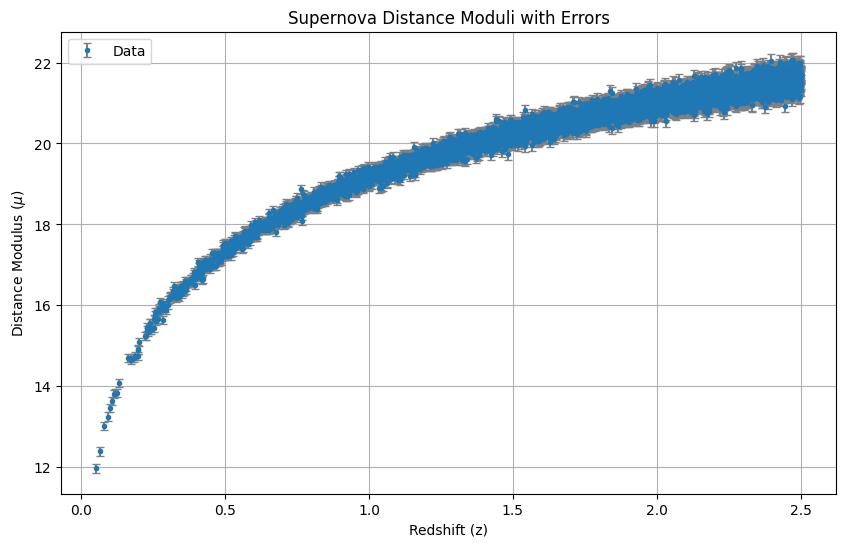

In [13]:
plt.figure(figsize=(10, 6))
plt.errorbar(zs, observed_distance_moduli, yerr=distance_moduli_errors, fmt='.', ecolor='gray', capsize=3, label='Data')
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus ($\mu$)')
plt.title('Supernova Distance Moduli with Errors')
plt.grid(True)
plt.legend()
plt.show()



### Binning the data

There is no way we can measure (up to now) $\delta z = 0.004$, so one way is to bin the data.

The idea is to say: we think we know the SNIa is there but I might be wrong. 

Let us assume we can measure $\delta = 0.03$

In [14]:
# Create the bins

err_z_meas = 0.03

bins = np.linspace(0, z_max, int((z_max-0)/err_z_meas) + 1)

num_bins = len(bins)


# Digitize the redshifts into bins
bin_indices = np.digitize(zs, bins) - 1  # Subtract 1 to convert to 0-based indexing


# Initialize lists to accumulate the binned values
mean_zs = []
weighted_mean_distance_moduli = []
weighted_errors = []
bin_centers = []

# Calculate the weighted mean values for each bin
for i in range(num_bins):
    in_bin = bin_indices == i  # Find which elements belong to the bin
    if np.sum(in_bin) > 0:
        # Get the values and weights in the bin
        z_vals = zs[in_bin]
        mu_vals = observed_distance_moduli[in_bin]
        errors = distance_moduli_errors[in_bin]
        weights = 1 / errors**2  # Weights are the inverse of the variance

        # Calculate the weighted mean for redshift and distance modulus
        mean_z = np.average(z_vals, weights=weights)
        weighted_mean_mu = np.average(mu_vals, weights=weights)

        # Calculate the weighted error (standard error)
        weighted_error = np.sqrt(1 / np.sum(weights))

        # Append the calculated values to the lists
        mean_zs.append(mean_z)
        weighted_mean_distance_moduli.append(weighted_mean_mu)
        weighted_errors.append(weighted_error)
        bin_centers.append((bins[i] + bins[i+1]) / 2)  # Center of the bin

# Convert lists to numpy arrays for plotting



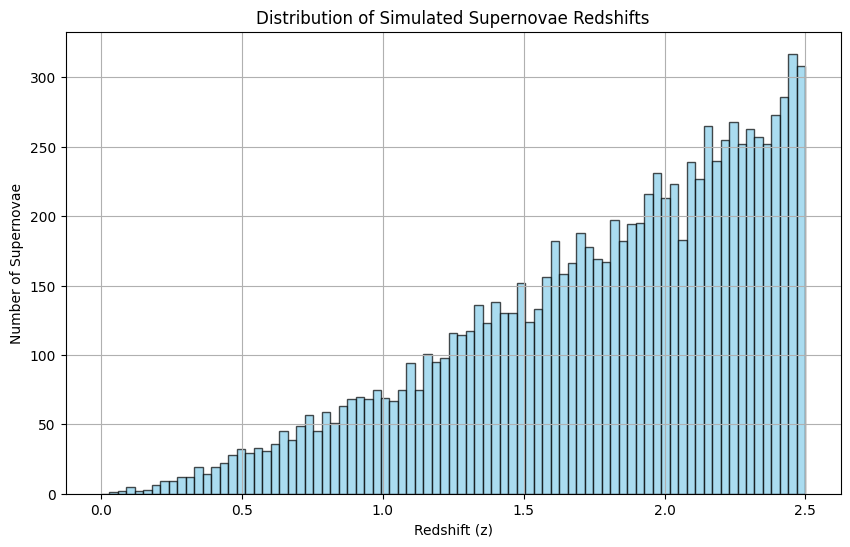

In [15]:

# Plot the supernova redshift distribution
plt.figure(figsize=(10, 6))
plt.hist(zs, bins=bins, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Redshift (z)')
plt.ylabel('Number of Supernovae')
plt.title('Distribution of Simulated Supernovae Redshifts')
plt.grid(True)
plt.show()

### Saving into files 

In [16]:
# Optionally, save to a file

mock_catalog = np.zeros([len(zs), 3])
for i in range(len(mock_catalog)): 
    mock_catalog[i][0] = zs[i]
    mock_catalog[i][1] = observed_distance_moduli[i]
    mock_catalog[i][2] = distance_moduli_errors[i]
    
np.savetxt("mock_supernova_catalog.dat", mock_catalog, fmt="%.6f", header="z mu sigma")



bin_mock_catalog = np.zeros([len(bin_centers), 3])
for i in range(len(bin_mock_catalog)): 
    bin_mock_catalog[i][0] = bin_centers[i]
    bin_mock_catalog[i][1] = weighted_mean_distance_moduli[i]
    bin_mock_catalog[i][2] = weighted_errors[i]
    
np.savetxt("bin_mock_supernova_catalog.dat", bin_mock_catalog, fmt="%.6f", header="z mu sigma")



In [17]:
eps = 0.01


# General function for computing derivatives with respect to any parameter
def derivative_mag(param_name, param_value, z, h, om, oml, w0):
    """
    Compute the derivative of the logarithm of the theoretical magnitude (mu_th)
    with respect to a given parameter (om, oml, or w0).

    Parameters:
    - param_name: The parameter with respect to which the derivative is computed ('om', 'oml', or 'w0')
    - param_value: The current value of the parameter
    - z, h, om, oml, w0: Other cosmological parameters

    Returns:
    - The numerical derivative of the log(mu_th) with respect to the parameter
    """
    # Lambda function to update the parameter based on param_name
    def update_param(value):
        if param_name == 'om':
            return np.log(mu_th(z, h, value, oml, w0))
        elif param_name == 'oml':
            return np.log(mu_th(z, h, om, value, w0))
        elif param_name == 'w0':
            return np.log(mu_th(z, h, om, oml, value))
        elif param_name == 'h': 
            return np.log(mu_th(z, value, om, oml, w0))
        else:
            raise ValueError("Invalid parameter name. Choose 'om', 'oml', or 'w0'.")

    # Compute the numerical derivative using central differences
    return numerical_derivative(update_param, param_value)

# Function for numerical derivatives using central differences
def numerical_derivative(func, var):
    """
    Compute the numerical derivative of a function using central differences.

    Parameters:
    - func: The function to differentiate
    - var: The variable with respect to which the derivative is computed

    Returns:
    - The numerical derivative value
    """
    var_up = var * (1 + eps)
    var_down = var * (1 - eps)
    return (func(var_up) - func(var_down)) / (2 * eps * var)



zref = 0.5

# Compute derivatives
dmag_dom = derivative_mag('om', om0ref, zref, href, om0ref, oml0ref, w0ref)
dmag_doml = derivative_mag('oml', oml0ref, zref, href, om0ref, oml0ref, w0ref)
dmag_dw0 = derivative_mag('w0', w0ref, zref, href, om0ref, oml0ref, w0ref)

print(f"dmag/dom: {dmag_dom}")
print(f"dmag/doml: {dmag_doml}")
print(f"dmag/dw0: {dmag_dw0}")

dmag/dom: -0.022212670906032742
dmag/doml: 0.02034624656219338
dmag/dw0: -0.018821552137482378


# Fisher Matrix for Type Ia Supernovae (SNIa) in Cosmology

The Fisher matrix formalism provides a framework to estimate the precision with which we can determine cosmological parameters using observational data. For Type Ia supernovae (SNIa), the key observable is the **distance modulus** as a function of redshift, which can be used to constrain the expansion history of the universe and cosmological parameters like the dark energy equation of state parameter \(w\).

## 1. Distance Modulus and Luminosity Distance

The observed **distance modulus** $ \mu(z) $ is related to the **luminosity distance** $ d_L(z) $ through the equation:
$ \mu(z) = 5 \log_{10}(d_L(z)) + 25 $
where $ d_L(z) $ is the luminosity distance at redshift $ z $, given by:
$ d_L(z) = (1 + z) \int_0^z \frac{c \, dz'}{H(z')} $
where $H(z')$ is the Hubble parameter as a function of redshift and $ c $ is the speed of light.

The Hubble parameter depends on cosmological parameters such as the matter density $ \Omega_m $, dark energy density $ \Omega_\Lambda $, and the dark energy equation of state $ w $. For a flat $ \Lambda $-Cold Dark Matter (LCDM) universe with a dark energy component:
$ H(z) = H_0 \sqrt{\Omega_m (1 + z)^3 + \Omega_\Lambda (1 + z)^{3(1 + w)}} $

## 2. Fisher Matrix Formalism

In the Fisher matrix approach, the Fisher matrix $ F $ is given by:
$ F_{\alpha \beta} = \sum_i \frac{1}{\sigma_{\mu,i}^2} \frac{\partial \mu(z_i)}{\partial p_\alpha} \frac{\partial \mu(z_i)}{\partial p_\beta} $
where:
- $ \mu(z_i) $ is the distance modulus at redshift $ z_i $,
- $ p_\alpha $ are the cosmological parameters of interest (e.g., $ H_0 $, $ \Omega_m $, $ w $, etc.),
- $ \sigma_{\mu,i} $ is the uncertainty on the distance modulus at redshift $ z_i $,
- The sum runs over all observed supernovae.

### Partial Derivatives
To calculate the Fisher matrix, we need the partial derivatives of the distance modulus with respect to the cosmological parameters:
$ \frac{\partial \mu(z)}{\partial p_\alpha} $
For this specific case, i.e. working with SNIa, the derivatives can be done analytically, for instance:
- For the matter density $ \Omega_m $:
$ \frac{\partial \mu(z)}{\partial \Omega_m} = -\frac{15}{2 \ln(10)} \frac{(1+z)^3}{H(z) d_L(z)} $
- For the dark energy equation of state $ w $:
$ \frac{\partial \mu(z)}{\partial w} = -\frac{15}{\ln(10)} \int_0^z \frac{(1+z')^3 \ln(1+z')}{H(z')} \, dz' $

These derivatives are then substituted into the Fisher matrix equation.

## 3. Error Forecasts

Once the Fisher matrix is computed, the **covariance matrix** of the parameters is given by the inverse of the Fisher matrix:
$ C_{\alpha \beta} = (F^{-1})_{\alpha \beta} $
The diagonal elements of the covariance matrix provide the **expected variance** on each parameter, and the square root of these elements gives the **1-sigma uncertainties**.

For example, if $ C_{w\,w} $ is the diagonal element corresponding to the equation of state parameter $ w $, then the uncertainty in $ w $ is:
$ \sigma_w = \sqrt{C_{w\,w}} $

## 4. Applications to Type Ia Supernovae

By applying the Fisher matrix formalism to a large sample of Type Ia supernovae, such as those that will be observed by the Vera Rubin Observatory's LSST, we can forecast the precision with which cosmological parameters can be measured. This technique allows us to quantify how well we can constrain:
- The **dark energy equation of state parameter** $ w $,
- The **matter density** $ \Omega_m $,
- The **Hubble constant** $ H_0 $,
- and other cosmological parameters.

The number of supernovae detected, their redshift distribution, and the uncertainties on their measurements directly affect the tightness of the constraints that can be obtained.

## 5. Systematic Uncertainties

In real-world applications, the Fisher matrix analysis must also account for **systematic uncertainties**. These include uncertainties in:
- **Supernova calibration** (absolute magnitude),
- **Redshift uncertainties**,
- **Host galaxy dust extinction**,
- **K-corrections**, etc.

These systematic errors can be incorporated into the Fisher matrix formalism by adding an appropriate covariance matrix for the systematics to the statistical uncertainties.


In [28]:

# Example set of uncertainties for the distance modulus at each redshift
# Replace with actual observational uncertainties (sigma_k)
#sigma_k = 0.01 * np.ones_like(z_values)  # Assuming constant uncertainty for simplicity




# Assume dmagdom_array, dmagdoml_array, and dmagdw0_array have already been computed
# These represent the derivatives of the distance modulus with respect to the parameters
dmu_dh = np.array([derivative_mag('h', href, z, href, om0ref, oml0ref, w0ref) for z in bin_centers])
dmu_dom = np.array([derivative_mag('om', om0ref, z, href, om0ref, oml0ref, w0ref) for z in bin_centers])
dmu_doml = np.array([derivative_mag('oml', oml0ref, z, href, om0ref, oml0ref, w0ref) for z in bin_centers])
dmu_dw0 = np.array([derivative_mag('w0', w0ref, z, href, om0ref, oml0ref, w0ref) for z in bin_centers])

# Initialize the Fisher matrix
Fisher_matrix = np.zeros((n_params, n_params))

# Parameters: [Omega_m, Omega_Lambda, w0]
derivatives = [dmu_dh, dmu_dom, dmu_doml, dmu_dw0]

# Number of parameters
n_params = len(derivatives)

# Compute the upper triangular part of the Fisher matrix
for i in range(n_params):
    for j in range(i, n_params):  # Only compute for j >= i
        # Summing over all redshifts
        Fisher_matrix[i, j] = np.sum((1 / np.array(weighted_errors)**2) * derivatives[i] * derivatives[j])

# Fill in the lower triangular part of the matrix (since it's symmetric)
for i in range(1, n_params):
    for j in range(i):
        Fisher_matrix[i, j] = Fisher_matrix[j, i]

# Print or return the Fisher matrix
print("Fisher Matrix:")
print(Fisher_matrix)


Fisher Matrix:
[[13667.19846236  5068.56463015 -1300.35240666  1632.79120312]
 [ 5068.56463015  2117.49532538  -446.43864547   614.23128846]
 [-1300.35240666  -446.43864547   134.49791605  -156.75456394]
 [ 1632.79120312   614.23128846  -156.75456394   196.8130229 ]]


In [29]:
cov_matrix = inv(Fisher_matrix)

err_params = [cov_matrix[i, i] for i in range(len(cov_matrix))]

param_names = [r'$h$', r'$\Omega_{m}$', r'$\Omega_{\Lambda}$', r'$w_0$']
param_values = np.array([href, om0ref, oml0ref, w0ref])

print(param_names)
print(err_params/abs(param_values))

['$h$', '$\\Omega_{m}$', '$\\Omega_{\\Lambda}$', '$w_0$']
[ 0.02917046  0.67877919  6.43768096 16.50382629]


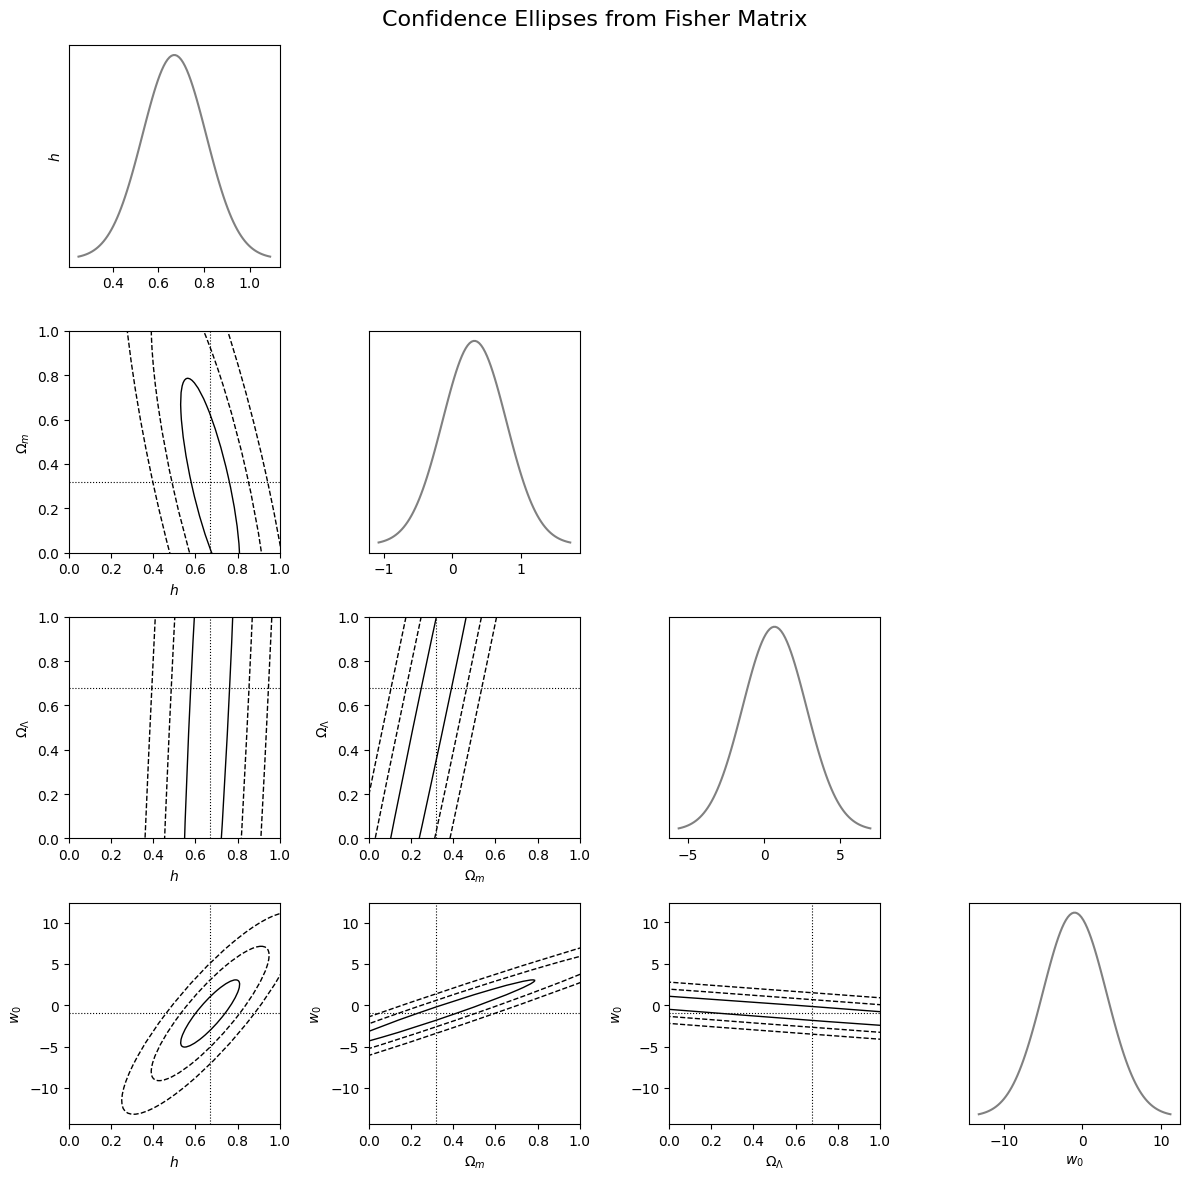

In [30]:
from matplotlib.patches import Ellipse

def plot_fisher_ellipses(fisher_matrix, param_names, param_values, confidence_levels=[1, 2, 3]):
    """
    Plot confidence ellipses from the Fisher matrix for each pair of parameters.

    Parameters:
    - fisher_matrix: The Fisher matrix (must be square and invertible).
    - param_names: A list of parameter names corresponding to the Fisher matrix.
    - param_values: An array of reference values for each parameter (centers of the ellipses).
    - confidence_levels: List of confidence levels to plot (default: [1, 2, 3] sigma).
    """
    # Invert the Fisher matrix to obtain the covariance matrix
    covariance_matrix = np.linalg.inv(fisher_matrix)
    num_params = len(param_names)
    
    # Create a figure for the ellipses
    fig, axes = plt.subplots(num_params, num_params, figsize=(12, 12))
    fig.suptitle('Confidence Ellipses from Fisher Matrix', fontsize=16)
    
    # Iterate over each pair of parameters
    for i in range(num_params):
        for j in range(num_params):
            ax = axes[i, j]
            if i == j:
                # Diagonal: Plot the 1D marginalized Gaussian distribution
                variance = covariance_matrix[i, i]
                sigma = np.sqrt(variance)
                x = np.linspace(param_values[i] - 3 * sigma, param_values[i] + 3 * sigma, 100)
                y = np.exp(-0.5 * ((x - param_values[i]) / sigma)**2)
                ax.plot(x, y, color='gray')
                ax.set_yticks([])
                if i == num_params - 1:
                    ax.set_xlabel(param_names[j])
                if j == 0:
                    ax.set_ylabel(param_names[i])
            elif j < i:
                # Off-diagonal: Plot the ellipses
                cov_ij = covariance_matrix[[i, j], :][:, [i, j]]
                center = (param_values[j], param_values[i])
                plot_confidence_ellipse(ax, cov_ij, center, confidence_levels)
                ax.set_xlabel(param_names[j])
                ax.set_ylabel(param_names[i])
            else:
                # Upper off-diagonal subplots are empty
                ax.set_visible(False)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

def plot_confidence_ellipse(ax, cov_matrix, center, confidence_levels):
    """
    Plot confidence ellipses for a given covariance matrix on a given axis.

    Parameters:
    - ax: The axis to plot on.
    - cov_matrix: The 2x2 covariance matrix for the two parameters.
    - center: Tuple containing the (x, y) coordinates of the center of the ellipse.
    - confidence_levels: List of confidence levels to plot (e.g., [1, 2, 3]).
    """
    # Calculate eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    largest_eigvec = eigenvectors[:, -1]  # The eigenvector associated with the largest eigenvalue
    angle = np.arctan2(largest_eigvec[1], largest_eigvec[0])
    angle_deg = np.degrees(angle)
    
    # Plot ellipses for each confidence level
    for n_sigma in confidence_levels:
        width, height = 2 * n_sigma * np.sqrt(eigenvalues)
        ellipse = Ellipse(xy=center, width=width, height=height, angle=angle_deg,
                          edgecolor='black', facecolor='none', linestyle='--' if n_sigma > 1 else '-')
        ax.add_patch(ellipse)

    ax.axhline(center[1], color='black', linestyle=':', linewidth=0.8)
    ax.axvline(center[0], color='black', linestyle=':', linewidth=0.8)


plot_fisher_ellipses(Fisher_matrix, param_names, param_values)
